<mark> <font size="3"> Suman Pan - 218352 </mark>


<mark> <font size="3"> Clara Llòria - 218147 </mark>

# Lab 2. Robust homography estimation: building image mosaics

In this practical session, we will create panoramic images by stitching multiple images of a scene taken from the same position, but pointing the camera to slightly different directions.  These images are related by homographies that we will need to compute.  The process will have the following steps:

- The first step will be to compute keypoints in the images that we can use to find correspondences.  We will use SIFT or ORB keypoints and features.
- Next we will compute correspondences between sets of keypoint features. We will use existing code for these first two steps.
- From the correspondences we will compute the homography that maps one image into the another. Since some correspondences may be erroneous, the computation will have to be robust to outliers. We will use the "RANdom SAmple Consensus" (RANSAC) method that you will have to complete.
- Finally, with the homographies computed, we will map all the images into a common canvas by using a variant of the  `apply_H` function from the last assignment.

Finally, you will have to answer the questions and complete the provided code when necessary as required. Some questions are rather theoretical and eventually imply some calculations while others are practical questions. **You must deliver the completed (and executed) ipynb file and a pdf file with the answers to the questions (included the parts of the code that need to be added).**

In [ ]:
# ! pip install plotly
# tenemos esto comentado en el utils,!!!!!!!!

In [ ]:
import numpy as np
import cv2
import random
import math
import sys
import matplotlib
from matplotlib import pyplot as plt
from operator import itemgetter
from utils import apply_H_fixed_image_size, Normalization, DLT_homography
import os

In [ ]:
# !pip install opencv-contrib-python==4.4.0.46

## **1. Compute image correspondences**

The first step is to read the images and to compute their keypoints. The images are RGB. We have to convert them to gray scale with values in order to compute the keypoints on them. Then, we compute the keypoints and descriptors of every image. For the parts where the content of the two images coincide, you can visually check that many of the detected points are detected in both images. We want to find these _correspondences_.

In [8]:
# Function to switch over ORB and SIFT methods and run just the code related to them
def get_method(type_num):
    switcher = {
        0: "ORB",
        1: "SIFT",
    }
    return switcher.get(type_num, "nothing")
## ESTARÍA GUAY PONER UN SWITCH Y LLAMAR A UNA FUNCIÓN U OTRA

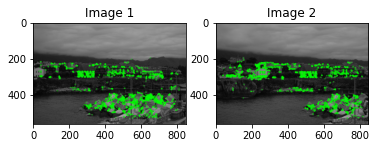

In [34]:
img1 = cv2.imread('Data/Llanes/llanes_a.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/Llanes/llanes_b.jpg',cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('Data/Llanes/llanes_c.jpg',cv2.IMREAD_GRAYSCALE)

# Initiate ORB detector
orb = cv2.ORB_create(3000)
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# draw only keypoints location,not size and orientation
img1b = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
img2b = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Image 1')
ax2.set_title('Image 2')
ax1.imshow(img1b); ax2.imshow(img2b)
plt.show()

# Add a flag to run only the ORB or SIFT method and avoid errors
flag_method = get_method(1)

**Q1.** Are the keypoints uniformly distributed over the image? Where are there more keypoints? Why?

<mark> <font size="3"> **Answer:** </mark>

The keypoints found are not uniformly distributed over the image, but we can find them at the areas where there the gradients on the same image are greater, that is, those zones where the changes in the edges are more noticeable since these areas will provide more distinguishable information to find the correspondences compared to more uniform areas.

To match the keypoints between two images, we need to assign to each keypoint in the first image the one that has the most similar descriptor in the second image. 

Execute the following code to find image correspondences using ORB [1] (you may also use SIFT [2], SURF [3], etc, an example of the use of SIFT is given in another code cell below).

[1] Ethan Rublee, Vincent Rabaud, Kurt Konolige, Gary R. Bradski. ORB: An efficient alternative to SIFT or SURF. ICCV, 2564-2571, 2011.

[2] David Lowe. Object recognition from local scale-invariant features. ICCV, 1150-1157, 1999.

[3] Herbert Bay, Tinne Tuytelaars, Luc Van Gool. Surf: Speeded up robust features. ECCV, 404-417, 2006.

<mark><font size="3"> **ORB:** </mark>

In [ ]:
# Keypoint matching

# OBR method
bf = cv2.BFMatcher()
    
matches_12 = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good_matches_12 = []
for m,n in matches_12:

    if m.distance < 0.85*n.distance:
        good_matches_12.append([m])

# Show "good" matches 
img_12 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In case you want to find SIFT correspondences you may use the code below. 

NOTE: SIFT is not available in certain OpenCV versions. A version that worked for us was opencv-contrib 4.4.0.46, you can install it with the following command: `pip install opencv-contrib-python==4.4.0.46`

<mark><font size="3"> **SIFT:** </mark>

In [ ]:
# Initiate SIFT detector

# Run only if we are in SIFT method
if flag_method != "ORB":

    sift = cv2.SIFT_create(3000)

    # find the keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # draw only keypoints location,not size and orientation
    img1b = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
    plt.imshow(img1b), plt.show()

    # Keypoint matching
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches_12 = bf.match(des1,des2)

    # Show matches
    img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_12)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

**Q2.**
Compute and visualize the matchings between image 2 and 3. Write the commands you used for that.

<mark> <font size="3"> **Between image 2 and 3:** </mark>

In [ ]:
# Initiate ORB detector

orb = cv2.ORB_create(3000)
# find the keypoints and descriptors with ORB
kp2, des2 = orb.detectAndCompute(img2,None)
kp3, des3 = orb.detectAndCompute(img3,None)

# draw only keypoints location,not size and orientation
img2b = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)
img3b = cv2.drawKeypoints(img3, kp3, None, color=(0,255,0), flags=0)
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Image 2')
ax2.set_title('Image 3')
ax1.imshow(img2b); ax2.imshow(img3b)
plt.show()

<mark><font size="3"> **ORB:** </mark>

In [ ]:
# Keypoint matching 
bf = cv2.BFMatcher()
matches_23 = bf.knnMatch(des2,des3,k=2)
# Apply ratio test
good_matches_23 = []
for m,n in matches_23:
    
    if m.distance < 0.85*n.distance:
        good_matches_23.append([m])

# Show "good" matches 
img_23 = cv2.drawMatchesKnn(img2,kp2,img3,kp3,good_matches_23,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_23)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

<mark><font size="3"> **SIFT:**</mark> 

In [ ]:
if flag_method != "ORB":
    # Initiate SIFT detector
    sift = cv2.SIFT_create(3000)

    # find the keypoints and descriptors
    kp2, des2 = sift.detectAndCompute(img2,None)
    kp3, des3 = sift.detectAndCompute(img3,None)

    # draw only keypoints location,not size and orientation
    img2b = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)
    plt.imshow(img2b), plt.show()

    # Keypoint matching
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches_23 = bf.match(des2,des3)

    # Show matches
    img_23 = cv2.drawMatches(img2,kp2,img3,kp3,matches_23,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_23)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

**Q3.**
Are all the matchings correct? Why?

<mark> <font size="3"> **Answer:** </mark>
Not all matches are correct, since there are some parts of the image that may be similar and therefore the algorithm detects that they are the same. Also, there are slightly different changes of view between the images that make the detection harder. Therefore, we need to apply some computations in order to distinguish between the good and bad matchings and take only those that describe it correctly.

## **2. Compute the homography (robust DLT algorithm) between image pairs**

We want now to compute the homography that relates each pair of images. From  the last assignment, we have a function called `DLT_homography` that computes a homography given a set of correspondences. Unfortunately, this only works when all of the correspondences are correct, which is not the case in most practical applictions as the current one. This time, we will need to use the RANSAC method in order to find the correct correspondences and discard the others.

For that we use the functions `Ransac_DLT_homography` and `Inliers` that you have 
to complete below (this is part of questions Q5 and Q6 below).


In [25]:
def Inliers(H, points1, points2, th):
   
    # Check that H is invertible
    if abs(math.log(np.linalg.cond(H))) > 15: 
        idx = np.empty(1)
        return idx
    
    inliers_indices = []
    # to normalize in case it is not
    points1/=points1[2,:]
    points2/=points2[2,:]
    # complete this code .......
    for j in range(points1.shape[1]):
        x_prima_j = points2[:,j]
        x_j = points1[:,j]
        
        dist1 = x_prima_j - np.dot(H, x_j)
        dist2 = np.dot(np.linalg.inv(H),x_prima_j)-x_j
        dist = np.linalg.norm(dist1) + np.linalg.norm(dist2)
        
        if dist<th:
            inliers_indices.append(j)
    
    
    return np.asarray(inliers_indices)

In [26]:
def Ransac_DLT_homography(points1, points2, th, max_it):
    
    Ncoords, Npts = points1.shape
    
    it = 0
    best_inliers = np.empty(1)

    while it < max_it:
        # choose only 4 samples
        L = 4 # number of samples to choose randomly
        indices = random.sample(range(1, Npts), L)
        # compute the homography for only those 4 samples 
        H = DLT_homography(points1[:,indices], points2[:,indices])
        # taking the computed H, check how much it relates to all points in the dataset
        # check the number of inliers that we obtain with that homograpgy
        inliers = Inliers(H, points1, points2, th)
        
        # test if it is the best model so far
        # save only the best inliers of all iterations, namely the one with more inliers
        if inliers.shape[0] > best_inliers.shape[0]:
            best_inliers = inliers
            
        # iterate again in case in the next iteration we obtain something better
        it += 1
    
    # compute H from all the inliers
    H = DLT_homography(points1[:,best_inliers], points2[:,best_inliers])
    inliers = best_inliers
    
    return H, inliers
    

The following code allows to robustly estimate the homography that relates images 1 and 2. Examine the code and answer the questions below.

**ORB:**

In [ ]:
# # # Homography between images 1 and 2
# if obr
if (flag_method == "ORB"):
    points1 = []
    points2 = []
    for m in good_matches_12: # matches_12 instead, if you use SIFT
        points1.append([kp1[m[0].queryIdx].pt[0], kp1[m[0].queryIdx].pt[1], 1]) # m.queryIdx instead, if you use SIFT
        points2.append([kp2[m[0].trainIdx].pt[0], kp2[m[0].trainIdx].pt[1], 1]) # m.trainIdx instead, if you use SIFT

    points1 = np.asarray(points1)
    points1 = points1.T
    points2 = np.asarray(points2)
    points2 = points2.T

**SIFT:**

In [ ]:
# # Homography between images 1 and 2 SIFTTTT
if (flag_method == "SIFT"):
    points1 = []
    points2 = []
    for m in matches_12: # matches_12 instead, if you use SIFT
        points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1]) # m.queryIdx instead, if you use SIFT
        points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1]) # m.trainIdx instead, if you use SIFT

    points1 = np.asarray(points1)
    points1 = points1.T
    points2 = np.asarray(points2)
    points2 = points2.T

In [ ]:
# # OBR
if flag_method == "ORB":
    th = 10
    H_12, indices_inlier_matches_12 = Ransac_DLT_homography(points1, points2, th, 1000)
    inlier_matches_12 = itemgetter(*indices_inlier_matches_12)(good_matches_12) # matches_12 instead, if you use SIFT

    # drawMatches instead of drawMatchesKnn if you use SIFT
    img_12 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,inlier_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_12)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

In [ ]:
# SIFT
if flag_method == "SIFT":
    th = 10
    H_12, indices_inlier_matches_12 = Ransac_DLT_homography(points1, points2, th, 1000)
    inlier_matches_12 = itemgetter(*indices_inlier_matches_12)(matches_12) # matches_12 instead, if you use SIFT

    print('indices: ', len(indices_inlier_matches_12))
    print('points: ', len(inlier_matches_12))
    
    # drawMatches instead of drawMatchesKnn if you use SIFT
    img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_12)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

**Q4.** What are the variables `points1` and `points2`?

Complete the `Ransac_DLT_homography` function by answering the following questions:

**Q5.** Set the number of samples to choose randomly and that will define the model to test in each trial. (second input parameter of function `random.sample`).

**Q6.** Complete the function `Inliers` by computing the geometric error of the correspondences given the homography.

**Q7.** What is the input parameter `th` when calling the `Ransac_DLT_homography` function? Choose a good value for this parameter and justify your answer.

**Q8.** Create a new function `Ransac_DLT_homography_adaptive_loop` which is based on the function `Ransac_DLT_homography` and automatically adapts the number of trials to ensure we pick, with a probability $p=0.99$ an initial data set with no outliers.

**Q9.** Compare experimentally the two versions of the RANSAC algorithm (`Ransac_DLT_homography` and `Ransac_DLT_homography_adaptive_loop`) in terms of the number of iterations. Which version is better and why?

**Q10.** Compute the homography that relates images 2 and 3. Write the commands you used for that.

Answer:

- Q4: son los maches entre los key points de la imagen 1 e imagen 2
- Q5: aunque se podrían escoger más samples, el mínimo que necesitamos para poder calcular la homografía son cuatro samples.
- Q7: es la distancia máxima (entre los puntos y sus proyecciones) para considerar que un match es descriptivo. HAY QUE HACER PRUEBA Y ERROR PARA ESCOGER EL THRESHOLD!!!!!!!!!!! SE PUEDE HACER UN BUCLE O A LO CUTRE
- Q9: la diferencia entre ambos métodos, es que al adaptar el numero de iteraciones en el segundo ganamos mucha eficiencia. Experimentalemente: observamos que con 1000 iteraciones en el primero, obtenemos aproximadamente el mismo numero de inliers (439) que en el segundo (aprox. 400-500) pero con muchas menos iteraciones, (140), con lo que ganamos mucho tiempo de ejecución.

In [55]:
# code to complete here ...
def Ransac_DLT_homography_adaptive_loop(points1, points2, th, max_it):
    
    Ncoords, Npts = points1.shape
    
    it = 0
    best_inliers = np.empty(1)
    
    N = 10000
    sample_count = 0
    s = 4
    p = 0.99
    
    # we put other condition to prevent if the fisrt N is very large number,
    # that is, we never iterate more than the max_it 
    while N > sample_count and sample_count < max_it:
        
        L = 4 # number of samples to choose randomly
        indices = random.sample(range(1, Npts), L)
        H = DLT_homography(points1[:,indices], points2[:,indices])
        inliers = Inliers(H, points1, points2, th)
        
        # test if it is the best model so far
        if inliers.shape[0] > best_inliers.shape[0]:
            best_inliers = inliers
        
        num_best_inliers = len(best_inliers)
        w = num_best_inliers / points1.shape[1]
        N = np.log(1-p)/np.log(1-(w**s))
        
#         print('N: ', N, '\n')
        
        sample_count += 1
            
        
    # compute H from all the inliers
    H = DLT_homography(points1[:,best_inliers], points2[:,best_inliers])
    inliers = best_inliers
    
    return H, inliers


In [ ]:
# CANVIAR A LA NUEVA FUNCIÓN
# # OBR
if flag_method == "ORB":
    th = 10
    H_12, indices_inlier_matches_12 = Ransac_DLT_homography_adaptive_loop(points1, points2, th)
    inlier_matches_12 = itemgetter(*indices_inlier_matches_12)(good_matches_12) # matches_12 instead, if you use SIFT

    # drawMatches instead of drawMatchesKnn if you use SIFT
    img_12 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,inlier_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_12)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

In [ ]:
# SIFT
if flag_method == "SIFT":
    th = 10
    H_12, indices_inlier_matches_12 = Ransac_DLT_homography_adaptive_loop(points1, points2, th)
    inlier_matches_12 = itemgetter(*indices_inlier_matches_12)(matches_12) # matches_12 instead, if you use SIFT

    
    print('indices: ', len(indices_inlier_matches_12))
    print('points: ', len(inlier_matches_12))
    
    # drawMatches instead of drawMatchesKnn if you use SIFT
    img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_12)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

In [ ]:
# # # Homography between images 2 and 3
# if obr
if (flag_method == "ORB"):
    points2 = []
    points3 = []
    for m in good_matches_23: # matches_23 instead, if you use SIFT
        points3.append([kp2[m[0].queryIdx].pt[0], kp2[m[0].queryIdx].pt[1], 1]) # m.queryIdx instead, if you use SIFT
        points3.append([kp3[m[0].trainIdx].pt[0], kp3[m[0].trainIdx].pt[1], 1]) # m.trainIdx instead, if you use SIFT

    points2 = np.asarray(points2)
    points2 = points2.T
    points3 = np.asarray(points3)
    points3 = points3.T

In [ ]:
# # Homography between images 2 and 3 SIFTTTT
if (flag_method == "SIFT"):
    points2 = []
    points3 = []
    for m in matches_23: # matches_23 instead, if you use SIFT
        points2.append([kp2[m.queryIdx].pt[0], kp2[m.queryIdx].pt[1], 1]) # m.queryIdx instead, if you use SIFT
        points3.append([kp3[m.trainIdx].pt[0], kp3[m.trainIdx].pt[1], 1]) # m.trainIdx instead, if you use SIFT

    points2 = np.asarray(points2)
    points2 = points2.T
    points3 = np.asarray(points3)
    points3 = points3.T

In [ ]:
# same as before but with img 2,3

# FALTA 10

# # OBR
if flag_method == "ORB":
    th = 10
    H_23, indices_inlier_matches_23 = Ransac_DLT_homography_adaptive_loop(points2, points3, th)
    inlier_matches_23 = itemgetter(*indices_inlier_matches_23)(good_matches_23) # matches_23 instead, if you use SIFT

    # drawMatches instead of drawMatchesKnn if you use SIFT
    img_23 = cv2.drawMatchesKnn(img2,kp2,img3,kp3,inlier_matches_23,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_23)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

In [ ]:
# SIFT
if flag_method == "SIFT":
    th = 10
    H_23, indices_inlier_matches_23 = Ransac_DLT_homography_adaptive_loop(points2, points3, th)
#     H_23, indices_inlier_matches_23 = Ransac_DLT_homography(points2, points3, th,1000)
    inlier_matches_23 = itemgetter(*indices_inlier_matches_23)(matches_23) # matches_23 instead, if you use SIFT

    
    print('indices: ', len(indices_inlier_matches_23))
    print('points: ', len(inlier_matches_23))
    
    # drawMatches instead of drawMatchesKnn if you use SIFT
    img_23 = cv2.drawMatches(img2,kp2,img3,kp3,inlier_matches_23,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_23)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

## **3. Build the mosaic**

At this point we have all the ingredients to built the image mosaic. For transforming an image with a specified homography we use a modification of the function `apply_H` used in the previous practical session. The modified function `apply_H_fixed_image_size` transforms the input image according to the input homography and writes it in an output image of size corresponding to the input vector of desired corner coordinates.

Examine and complete the code below when necessary.

**Q11.** Which homography we use for transforming the image 2? Why?

**Q12.** How are the two images combined in the mosaic image? Why?

**Q13.** Complete the mosaic including the third image. Write the commands you used for that.

Answer>

- Q11: H_12, explicar que es la homografia con mejor transfomacion para encontrar las corresp, de acuerdo con la distancia y thr entre los puntos y sus proyecciones.'??
- Q12: Usamos uno como el transformado, y otro como el fijo y los combinamos con la H anterior. algo asi. (Mejorar la explicacion)


In [ ]:
corners = [-400, 1200, -100, 650]

#print(img1.shape)
img1c = cv2.imread('Data/Llanes/llanes_a.jpg',cv2.IMREAD_COLOR)
img2c = cv2.imread('Data/Llanes/llanes_b.jpg',cv2.IMREAD_COLOR)
img3c = cv2.imread('Data/Llanes/llanes_c.jpg',cv2.IMREAD_COLOR)
img1c = cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB)
img2c = cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB)
img3c = cv2.cvtColor(img3c, cv2.COLOR_BGR2RGB)

# mosaic 1-2
img1c_w = apply_H_fixed_image_size(img1c, H_12, corners)
img2c_w = apply_H_fixed_image_size(img2c, np.identity(3), corners)
img_mosaic_12 = np.maximum(img1c_w,img2c_w)
plt.imshow(img_mosaic_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

# mosaic 2-3
img2c_w = apply_H_fixed_image_size(img2c, H_23, corners)
img3c_w = apply_H_fixed_image_size(img3c,np.identity(3) , corners)
img_mosaic_23 = np.maximum(img2c_w,img3c_w)
plt.imshow(img_mosaic_23)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

# mosaic 1-2-3

# ... complete ...
img1c_w_p = apply_H_fixed_image_size(img1c,H_12, corners)
img2c_w_p = apply_H_fixed_image_size(img2c,np.identity(3), corners) 
img3c_w_p = apply_H_fixed_image_size(img3c,np.linalg.inv(H_23), corners)

img_mosaic_12_p = np.maximum(img1c_w_p, img2c_w_p)
img_mosaic_23_p = np.maximum(img2c_w_p, img3c_w_p)
img_mosaic_123 = np.maximum(img_mosaic_12_p, img_mosaic_23_p)

plt.imshow(img_mosaic_123)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()


<mark> <font size="4"> **Analization for images of Llanes folder** </mark>

In this case it works perfectly, since we obtain a considerable number of key points and theirs respectively SIFT descriptors (which is a descriptor very discriminative). Also, we obtain a considerable number of theirs correspondences by marching these features, and discard those are outliers using RANSAC algorithm. Then to find the homography we also use DLT given a set of correct correspondences. Finally, we use this homography to obtain the final mosaic image.

So, it works well when the image is in well-defined condition, where there is able to find numerous of correspondences easily.
    

**Q14.** **(Optional)** Create a function that takes as input the path to the folder where the images to construct the panorama are located. The function should work independently of the number of images that are located in the folder (assume that the images are given in the correct order).

In [ ]:
img3c = cv2.imread('Data/Arboles/Arboles1.png',cv2.IMREAD_COLOR)
img1c = cv2.cvtColor(img3c, cv2.COLOR_BGR2RGB)
           
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Image 1')
ax2.set_title('Image 2')
ax1.imshow(img3c); ax2.imshow(img1c)
plt.show()

In [4]:
import os
import numpy as np
import cv2
import random
import math
import sys
import matplotlib
from matplotlib import pyplot as plt
from operator import itemgetter
from utils import apply_H_fixed_image_size, Normalization, DLT_homography
#

In [60]:
def panorama(path_images, th, max_it, num_of_kp , corners, plot_matches):
    
    # INPUTS:
        #path_images: path to the folder that contain the images
    # OTPUT: 
        # P: panoarama image    
    
    # 1) READ ALL THE IMAGES OF THE INPUT PATH  
    images = os.listdir(path_images)
    if '.DS_Store' in images:
        images.remove('.DS_Store')

    img_list_gray = []
    img_list_rgb = []
    for image in images:
        full_path = path_images + '/' + image
        img_list_gray.append(cv2.imread(full_path,cv2.IMREAD_GRAYSCALE))
        img_list_rgb.append(cv2.imread(full_path,cv2.IMREAD_COLOR))
    
    img1 = img_list_gray[0]
    img2 = img_list_gray[1]
    h, w = img1.shape[:2]
    img1c = cv2.cvtColor(img_list_rgb[0], cv2.COLOR_BGR2RGB)
    img2c = cv2.cvtColor(img_list_rgb[1], cv2.COLOR_BGR2RGB)
    
    # 2) COMPUTE THE IMAGE KEYPOINTS OF THE IMAGES
    print("COMPUTE THE IMAGE KEYPOINTS OF THE IMAGES...")
    # ORB
#     orb = cv2.ORB_create(num_of_kp)
#     # find the keypoints and descriptors with ORB
#     kp1, des1 = orb.detectAndCompute(img1,None)
#     kp2, des2 = orb.detectAndCompute(img2,None)
    
#     # draw only keypoints location,not size and orientation
#     img1b = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
#     img2b = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)

#     bf = cv2.BFMatcher()
#     matches_12 = bf.knnMatch(des1,des2,k=2)
#     # Apply ratio test
#     good_matches_12 = []
#     for m,n in matches_12:

#         if m.distance < 0.85*n.distance:
#             good_matches_12.append([m])
            
    # SIFT
    sift = cv2.SIFT_create(num_of_kp)

    # find the keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # 3) MATCH THE KEYPOINTS
    print("MATCH THE KEYPOINTS...")

    #PLOT of KEYPOINTS draw only keypoints location,not size and orientation
#     img1b = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
#     plt.imshow(img1b), plt.show()

    # Keypoint matching
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches_12 = bf.match(des1,des2)


     #  PLOT Show matches
#         img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#         plt.imshow(img_12)
#         fig = matplotlib.pyplot.gcf()
#         fig.set_size_inches(18.5, 10.5)
#         plt.show()

    # 4) COMPUTE THE HOMOGRAPIES
    print("COMPUTE THE HOMOGRAPIES...")
    points1 = []
    points2 = []
    for m in matches_12: # matches_12 instead, if you use SIFT
        points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1]) # m.queryIdx instead, if you use SIFT
        points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1]) # m.trainIdx instead, if you use SIFT

    points1 = np.asarray(points1)
    points1 = points1.T
    points2 = np.asarray(points2)
    points2 = points2.T

    H_12, indices_inlier_matches_12 = Ransac_DLT_homography_adaptive_loop(points1, points2, th, max_it)
    
    if plot_matches:
        inlier_matches_12 = itemgetter(*indices_inlier_matches_12)(matches_12) # matches_12 instead, if you use SIFT

        img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img_12)
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.show()

    # 5) BUILD THE MOSAIC
    print("BUILD THE MOSAIC...")
    img1c_w = apply_H_fixed_image_size(img1c, H_12, corners)
    img2c_w = apply_H_fixed_image_size(img2c, np.identity(3) , corners)
    img_mosaic_12 = np.maximum(img1c_w,img2c_w)

    plt.imshow(img_mosaic_12)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()
    
    return img_mosaic_12


**Q15** Construct the panorana image of each folder present in the Data folder and explain why it works or not in each case. In the scenarios that it does not work properly, suggest how you would try to improve the result obtained.

Note 1 : Use the function created above if the case, otherwise repeate the code for each pair of images.

Note 2: You will need to define new corner for panoram as the images bigger and positioned different, trick look the dimension of the images to thefine the corners of each case.

COMPUTE THE IMAGE KEYPOINTS OF THE IMAGES...
MATCH THE KEYPOINTS...
COMPUTE THE HOMOGRAPIES...
BUILD THE MOSAIC...


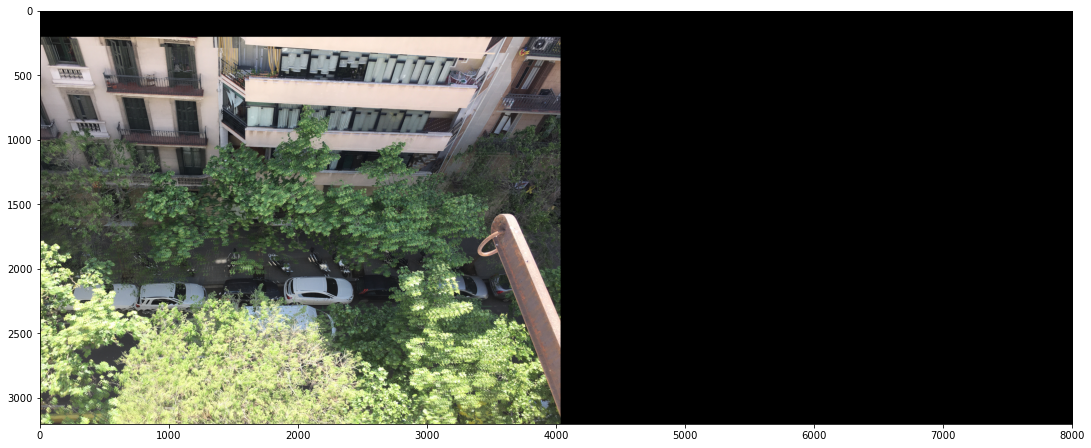

In [72]:
th = 50
max_it = 1000
num_of_kp = 3000
path_images = 'Data/Arboles'
corners = [0, 8000, -200, 3000] #corners = [-400, 1200, -100, 650]
img_mosaic_arbol = panorama(path_images, th, max_it, num_of_kp, corners, plot_matches = False)


Data/Ascensor/Textura1.png
Data/Ascensor/Textura2.png
MATCH THE KEYPOINTS DONETE
COMPUTE THE HOMOGRAPIES


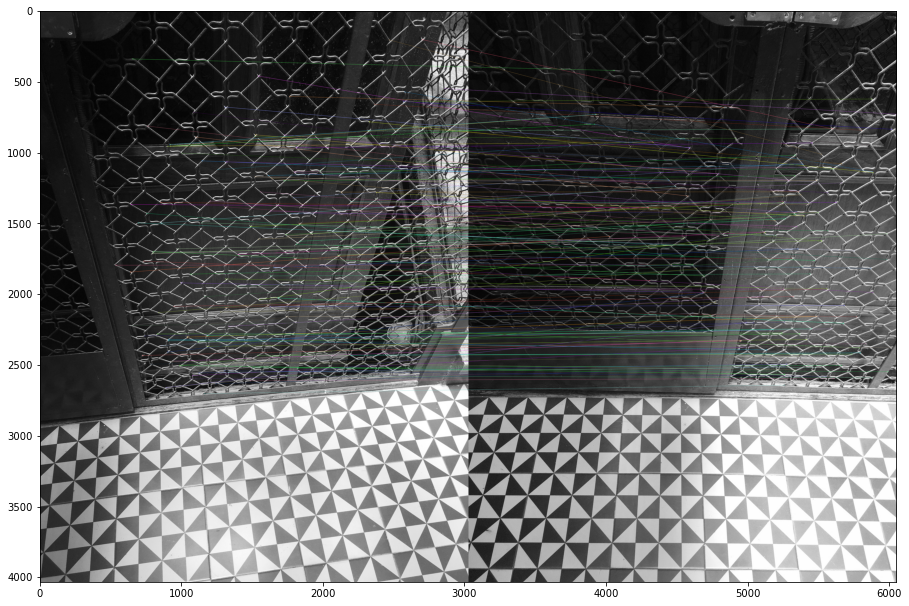

BUILD THE MOSAIC


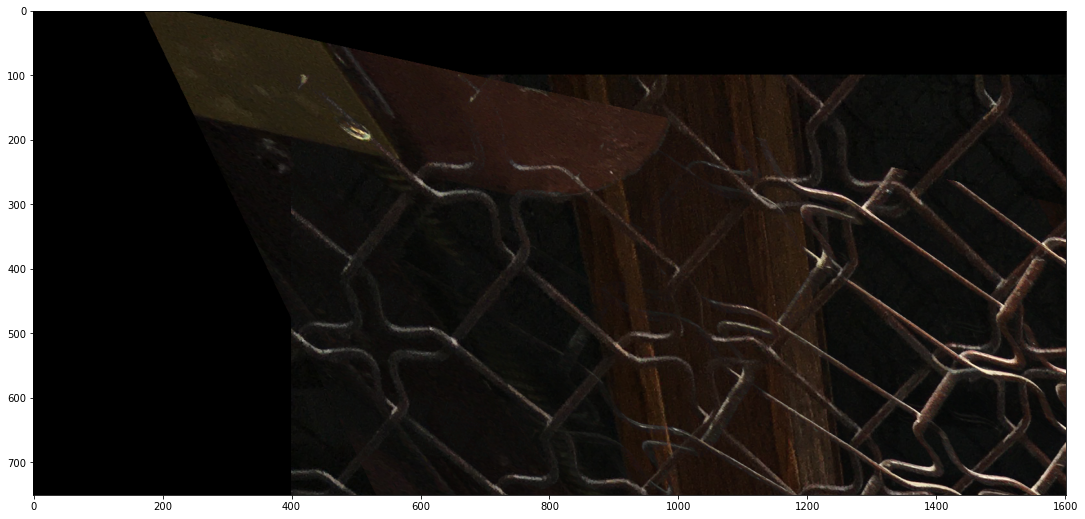

In [53]:
th = 50
max_it = 1000000
L = 4
num_of_kp = 9000
path_images = 'Data/Ascensor'
img_mosaic_ascensor = panorama(path_images, th, max_it, num_of_kp)

Data/Barceloneta/IMG_2234.JPG
Data/Barceloneta/IMG_2235.JPG
MATCH THE KEYPOINTS DONETE
COMPUTE THE HOMOGRAPIES


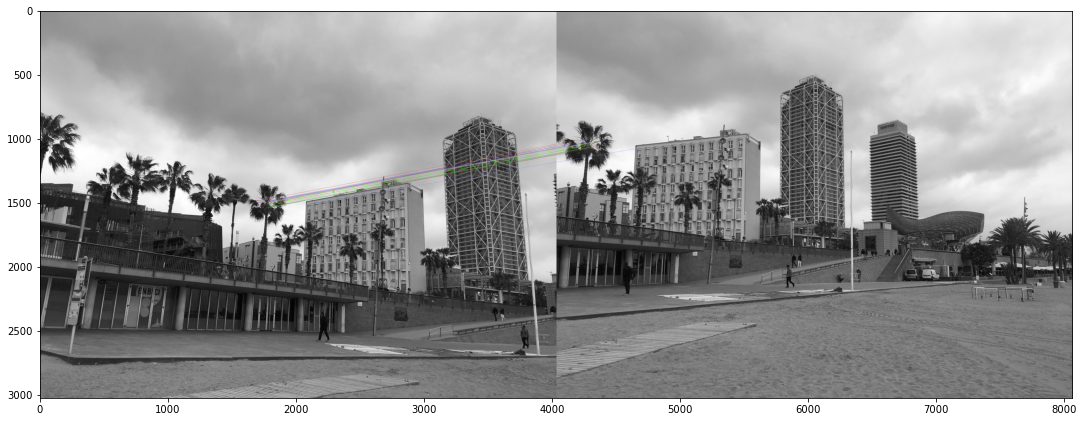

BUILD THE MOSAIC


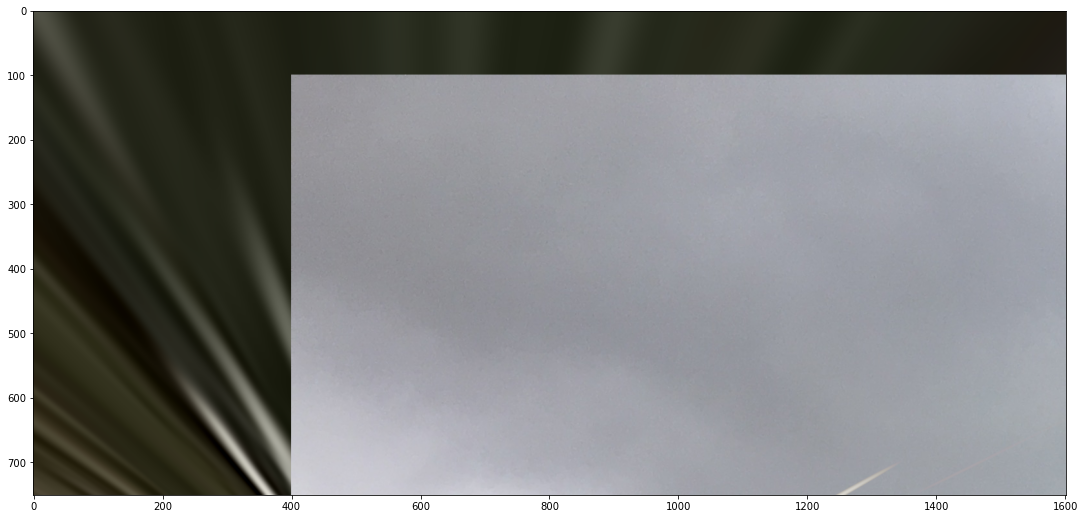

In [44]:
th = 1000
path_images = 'Data/Barceloneta'
panorama(path_images, th)   

Data/Cuadros/Cuadro1.png
Data/Cuadros/Cuadro2.png
MATCH THE KEYPOINTS DONETE
COMPUTE THE HOMOGRAPIES


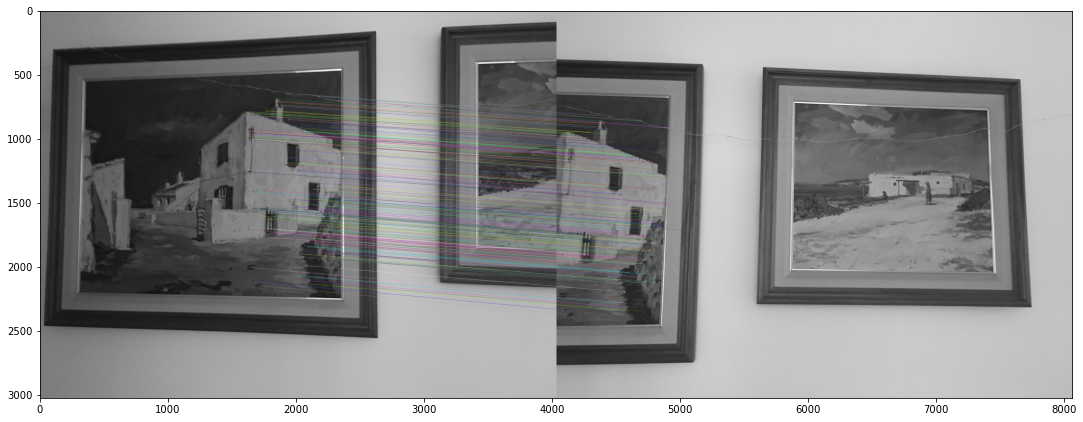

BUILD THE MOSAIC


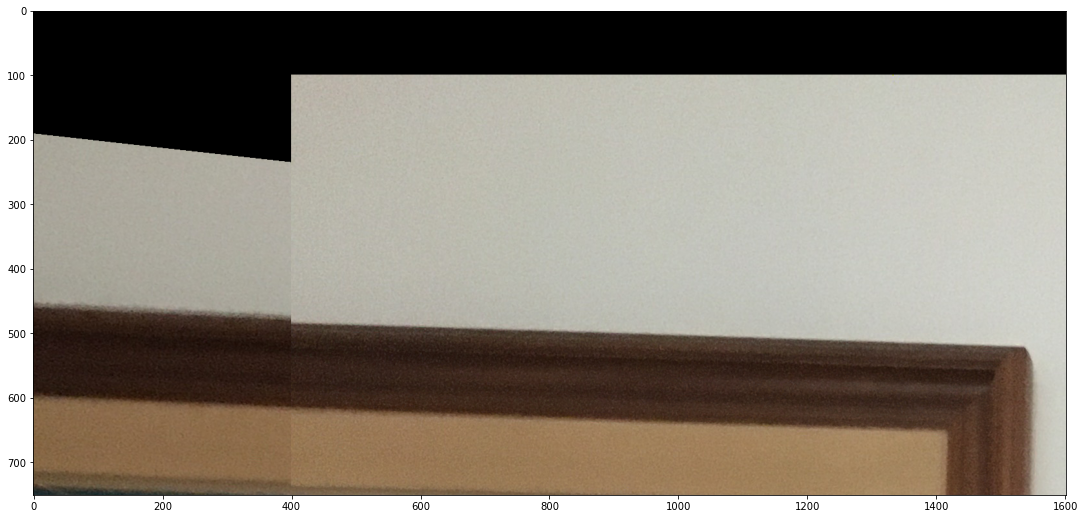

In [45]:
th = 1000
path_images = 'Data/Cuadros'
panorama(path_images, th)

COMPUTE THE IMAGE KEYPOINTS OF THE IMAGES...
MATCH THE KEYPOINTS...
COMPUTE THE HOMOGRAPIES...


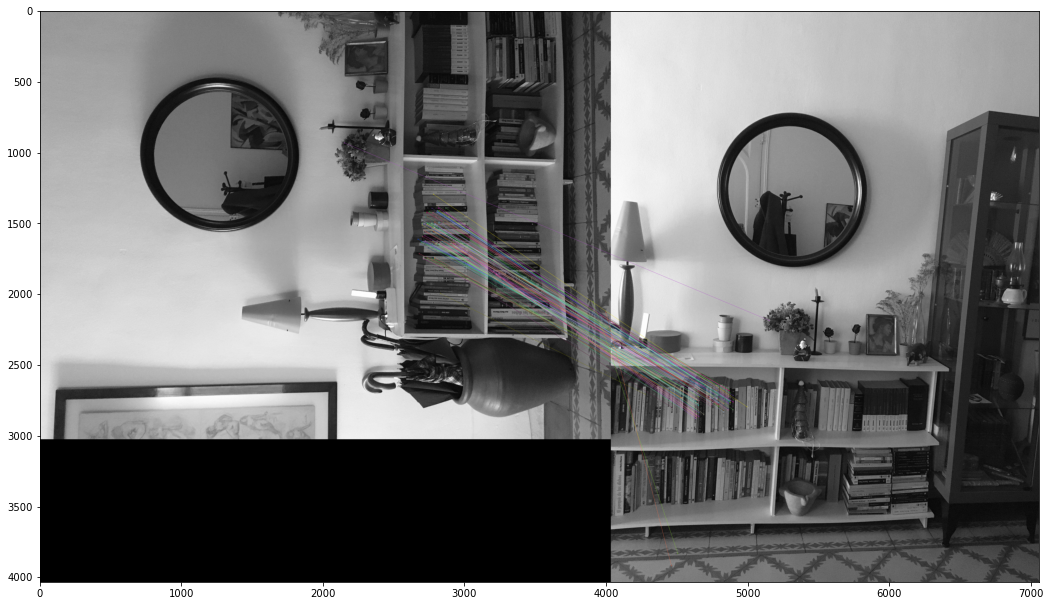

BUILD THE MOSAIC...


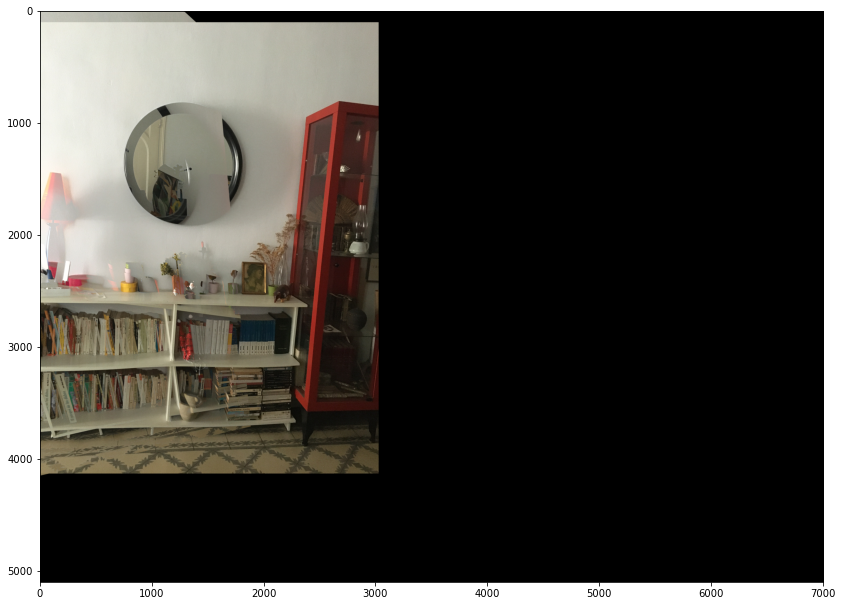

In [85]:

th = 100
max_it = 1000
num_of_kp = 3000*2
path_images = 'Data/Entrada'
corners = [0, 7000, -100, 5000] 
img_mosaic_arbol = panorama(path_images, th , max_it, num_of_kp , corners, plot_matches = True)


COMPUTE THE IMAGE KEYPOINTS OF THE IMAGES...
MATCH THE KEYPOINTS...
COMPUTE THE HOMOGRAPIES...


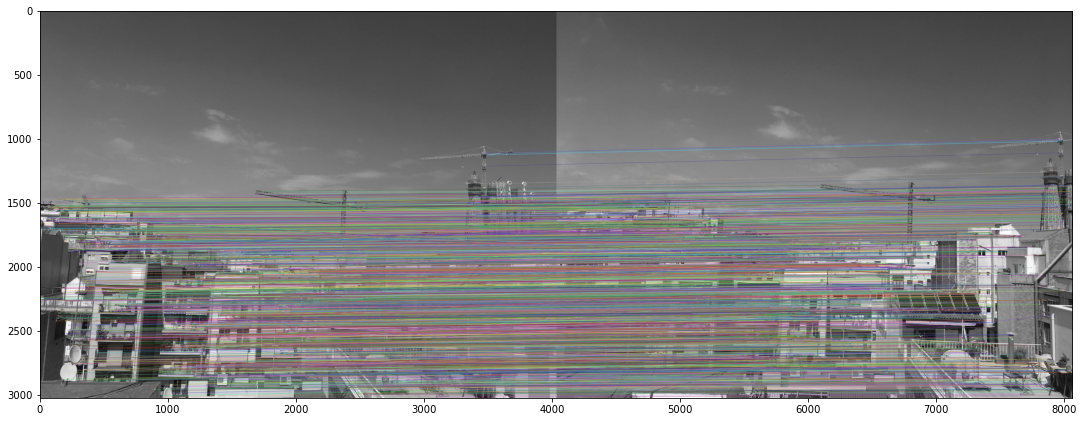

BUILD THE MOSAIC...


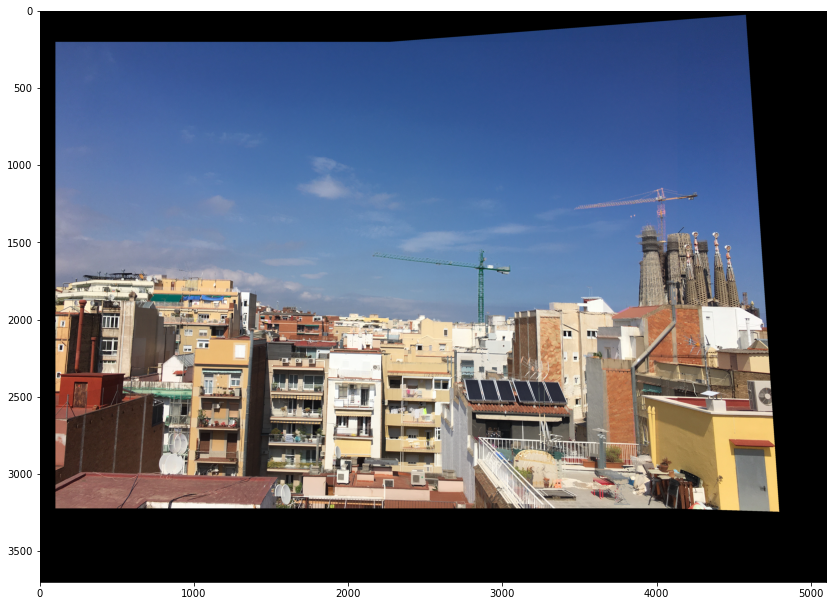

In [94]:

th = 900
max_it = 1000
num_of_kp = 10000
path_images = 'Data/Exterior'
corners = [-100, 5000, -200, 3500] 
img_mosaic_arbol = panorama(path_images, th , max_it, num_of_kp , corners, plot_matches = True)

<mark> <font size="3"> **Analization for images of Exterior folder** </mark>

In this case, it works partially, we can observe that from left to the middle of the image, we get a quite good results. But in the right part of the image, we fail, since there can observe some kind of overlap that should not been seen.
This is because we have not sufficiently correspondences matches between this right part, since all the correspondences that we need to find above the buildings on the right are small size without a lot of details. Even though, increasing the number of key points and the threshold, we obtain good correspondences from left to the middle.
So to improve this result, we need more correspondences of that area, for example where is the building of Sagrada Família, by giving images with bigger details in that area, and increasing the number of the (th, kp, etc.)

COMPUTE THE IMAGE KEYPOINTS OF THE IMAGES...
MATCH THE KEYPOINTS...
COMPUTE THE HOMOGRAPIES...


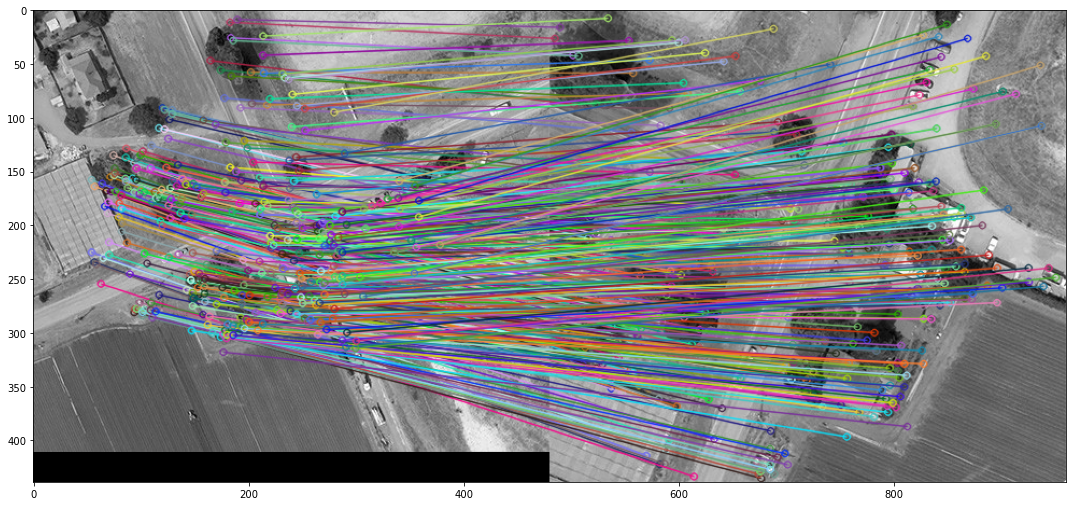

BUILD THE MOSAIC...


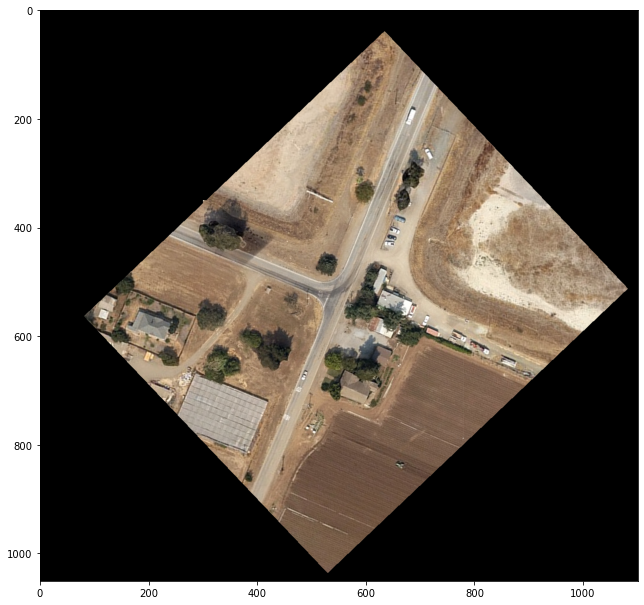

In [79]:

th = 10
max_it = 1000
num_of_kp = 3000
path_images = 'Data/Satelite'
corners = [-300, 800, -350, 700] 
img_mosaic_arbol = panorama(path_images, th , max_it, num_of_kp , corners, plot_matches = True)


COMPUTE THE IMAGE KEYPOINTS OF THE IMAGES...
MATCH THE KEYPOINTS...
COMPUTE THE HOMOGRAPIES...


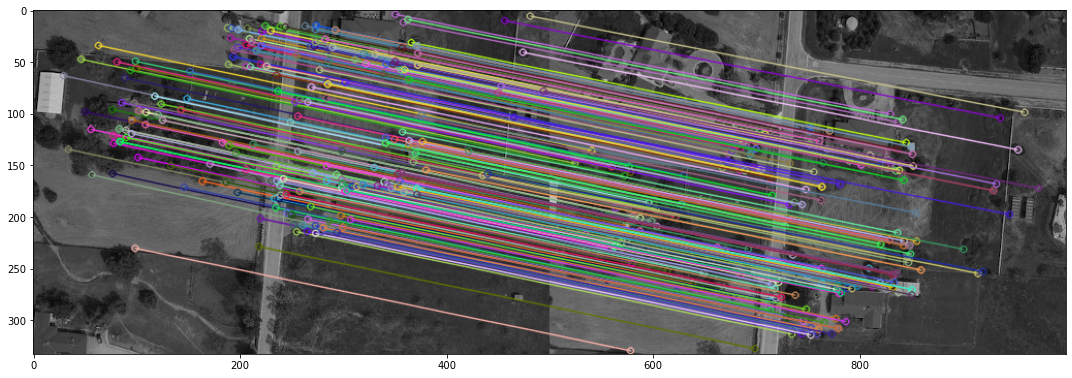

BUILD THE MOSAIC...


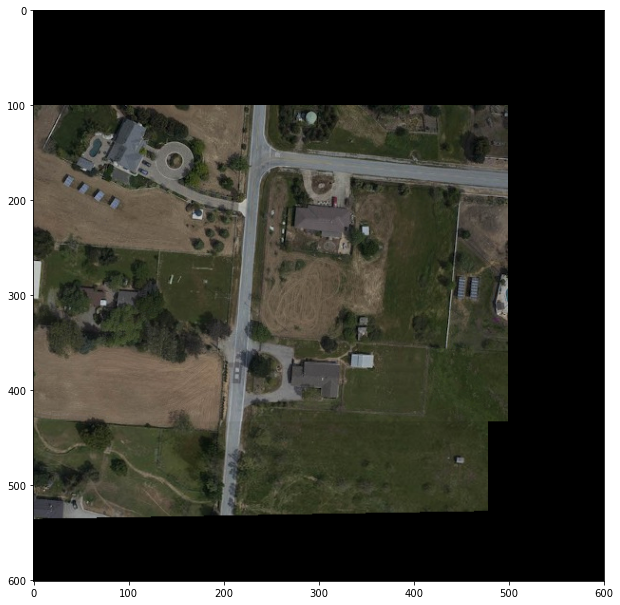

In [71]:


th = 10
max_it = 1000
num_of_kp = 3000
path_images = 'Data/Satelite2'
corners = [0, 600, -100, 500] 
img_mosaic_arbol = panorama(path_images, th , max_it, num_of_kp , corners, plot_matches = True)


<mark> <font size="3"> **Analization for images of Satelite and Satelite 2 folders** </mark>
<!-- d explain why it works or not in each case. In the scenarios that it does not work properly, suggest how you would try to improve the result obtained. -->
    
In this case it works, since the algorithm use SIFT descriptors (which is invariant to rotation and scale), and even though there is a slighly change of rotation to the right, it is able to find a considerable number of descriptors and theirs correspondences, therefore it is expected that it works well.